In [ ]:
# import libraries/packages
# Neural Network:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler
# for Transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from copy import copy
# for import directory
import os
# for reading .nii.gz files
import nibabel as nib
import scipy.ndimage as ndi
import re
# cv2 and numpy
import cv2
import numpy as np
# for visual
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
# Define paths
train_path = 'Datasets/MSSEG-2016/Training'
test_path = 'Datasets/MSSEG-2016/Testing'

In [ ]:
# Extract paths
FLAIR_path = []
mask_path = []
for subdir, dirs, files in os.walk(train_path):
    for file in files:
      if re.fullmatch('FLAIR_preprocessed.nii.gz', file):
        filename = os.path.join(subdir, file)
        FLAIR_path.append(filename)
      if re.fullmatch('Consensus.nii.gz', file):
        filename = os.path.join(subdir, file)
        mask_path.append(filename)

In [ ]:
# sanity check that associated FLAIR and masks are loaded
print(len(FLAIR_path))
print(len(mask_path))

15
15


In [ ]:
# for data loading
def read_nifti(path):
  # many slices have a blank mask (need to remove these)
  scan = nib.load(path).get_fdata()
  return scan

# resize the scan using zoom function
def resize_scan(scan):
  des_h = 128
  des_w = 128
  #des_d = 64

  w,h,d = scan.shape

  scan = np.delete(scan, slice(d-d//4, d), 2)
  scan = np.delete(scan, slice(0, d//2), 2)

  d = d-d//2-d//4

  res_h = des_h/h
  res_w = des_w/w
  #res_d = des_d/d

  scan = ndi.zoom(scan, (res_w, res_h, 1), order=1)
  scan = ndi.rotate(scan, 90)

  # convert to float to work with nn (original uint16 not supported)
  scan = np.float32(scan)

  # reorder to channel, width, height (tensor format)
  scan = np.transpose(scan, (2, 0, 1))
  return scan

# data loading process
def process_scan(path):
  scan = read_nifti(path)
  scan = resize_scan(scan)
  return scan

In [ ]:
# Load FLAIR and mask scans
FLAIR_scans = []
mask_scans = []
FLAIR_scans = [process_scan(path) for path in FLAIR_path]
mask_scans = [process_scan(path) for path in mask_path]

In [ ]:
# sanity check for ensuring uniform sizes of scans
for i in range(len(FLAIR_scans)):
  print(FLAIR_scans[i].shape)

(84, 128, 128)
(84, 128, 128)
(84, 128, 128)
(84, 128, 128)
(84, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)


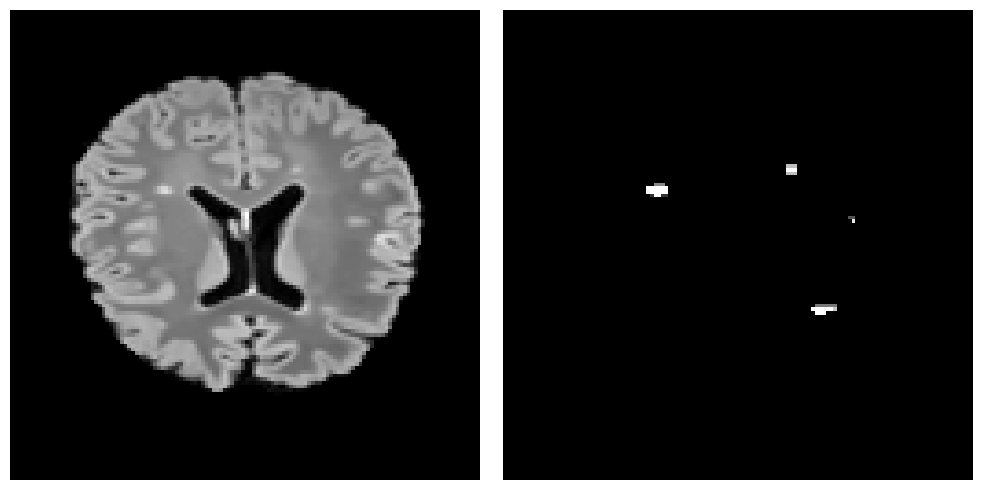

In [ ]:
fig_rows = 1
fig_cols = 2

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 5])

axs.flat[0].imshow(FLAIR_scans[7][50, :, :], cmap='gray')
axs.flat[0].axis('off')
axs.flat[1].imshow(mask_scans[7][50, :, :], cmap='gray')
axs.flat[1].axis('off')
        
plt.tight_layout()
plt.show()

In [ ]:
# flatten 
imageScans = np.concatenate(FLAIR_scans)
maskScans = np.concatenate(mask_scans)

In [ ]:
print(imageScans.shape)
print(maskScans.shape)

(1380, 128, 128)
(1380, 128, 128)


In [ ]:
# Custom Class for Loading the Dataset
# Dataset Loading Class
class LoadDataset(Dataset):
    def __init__(self, imageScan , maskScan, transform):
        self.imageScan = imageScan
        self.maskScan = maskScan
        self.transform = transform

    # returns number of images in dataset/directory
    def __len__(self):
        return len(self.imageScan)

    # return the image and mask in dataset
    def __getitem__(self, idx):
        imageScan = self.imageScan
        maskScan = self.maskScan

        # extract slice by slice
        image = imageScan[idx]
        mask = maskScan[idx]

        # binarize mask
        mask[mask >= 1] = 1.0                             

        # Apply basic transforms (rescale, to tensor, and normalize)
        if self.transform is not None:
          # Apply same tranform to image and mask
          transformed = self.transform(image=image, mask=mask)
          image = transformed['image']
          mask = transformed['mask']

        return image, mask

In [ ]:
# Create U-Net Neural Network as seen in Figure above
class Unet2D(nn.Module):
    def __init__(self):
        super().__init__()
        #encoding path
        self.layer1 = self.encLayer(1, 64)
        self.layer2 = self.encLayer(64, 128)
        self.layer3 = self.encLayer(128, 256)
        self.layer4 = self.encLayer(256, 512)
        self.pool = nn.MaxPool2d(2,2)
        #decoding path (concatenate with outputs from encoding layers)
        self.layer5 = self.decLayer(256+512, 256)
        self.layer6 = self.decLayer(256+128, 128)
        self.layer7 = self.decLayer(64+128, 64)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        #output layer
        self.out = self.outLayer(64,1)

    # Encoding layer consists of (2): Conv2d + BatchNorm + Relu
    # filter size = 3, padding = 1, stride = 1
    # no biases due to batching
    def encLayer(self, inCh, outCh):
        Encode = nn.Sequential(
            nn.Conv2d(inCh, outCh, 3, 1, 1, bias=False),
            nn.BatchNorm2d(outCh),
            nn.ReLU(inplace=True),
            nn.Conv2d(outCh, outCh, 3, 1, 1, bias=False),
            nn.BatchNorm2d(outCh),
            nn.ReLU(inplace=True))
        return Encode

    # Decoding Layer consists of (2): Conv2D + BachNorm + ReLu
    def decLayer(self, inCh, outCh):
        Decode = nn.Sequential(
            nn.Conv2d(inCh, outCh, 3, 1, 1, bias=False),
            nn.BatchNorm2d(outCh),
            nn.ReLU(inplace=True),
            nn.Conv2d(outCh, outCh, 3, 1, 1, bias=False),
            nn.BatchNorm2d(outCh),
            nn.ReLU(inplace=True))
        return Decode
    
    # Output Layer consists of: Conv2D + Sigmoid 
    def outLayer(self, inCh, outCh):
        Output = nn.Sequential(
            nn.Conv2d(inCh, outCh, 3, 1, 1),
            nn.Sigmoid())
        return Output

    # Create forward path for U-net
    def forward(self, x):
        # encoding path
        x1 = self.layer1(x)
        x2 = self.layer2(self.pool(x1))
        x3 = self.layer3(self.pool(x2))
        x4 = self.layer4(self.pool(x3))
        # decoding path (concatenate outputs from encoding path)
        x5 = self.layer5(torch.cat([self.up(x4), x3], 1))
        x6 = self.layer6(torch.cat([self.up(x5), x2], 1))
        x7 = self.layer7(torch.cat([self.up(x6), x1], 1))
        # output
        output = self.out(x7)
        return output

In [ ]:
# Create class for Custom Loss Function
# SoftDICE Loss Function Class
class SoftDice(nn.Module):
    def __init__(self):
        super().__init__()
    
    # forward execution to calcuate Loss
    def forward(self, y_true, y_hat):
        # flatten the inputs into vectors of (1 by batch*#ch*height*width)
        y_true = y_true.view(1, -1)
        y_hat = y_hat.view(1, -1)

        # calculate intersection and union
        intersection = (y_true*y_hat).sum()
        union = y_true.sum() + y_hat.sum()
        
        # calculate Soft DICE score
        e = 1.0
        dice = (2.*intersection + e)/(union + e)
        
        # calculate Soft DICE loss
        sdloss = 1. - dice
        
        return sdloss

In [ ]:
# Use GPU (cuda) for Training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# Pin memory for GPU
PIN_MEMORY = True if DEVICE == "cuda" else False

cuda


In [ ]:
# Define transforms applied to Validation and Testing Set
T_all = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=(0.0), std=(1.0), max_pixel_value=255.0,),
    ToTensorV2()
])

# Define transforms applied to Training Set
T_train = A.Compose([
    A.Resize(128, 128),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5, border_mode=1, value=0, mask_value=0),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.0), std=(1.0), max_pixel_value=255.0,),
    ToTensorV2()
])

In [ ]:
# Some hyperparameters
batch_sz = 8  # batch size
n_ep = 100     # number of epochs
LR = 0.002    # learning rate

In [ ]:
# Load Dataset
dataset = LoadDataset(imageScans, maskScans, transform=T_all)

# split randomly into 80-10-10 train-val-test
generator = torch.Generator().manual_seed(42)
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

# apply data augmentation to train_set
train_set.dataset = copy(dataset)
train_set.dataset.transform = T_train

# create dataloaders
trainLoader = DataLoader(train_set, batch_size=batch_sz, shuffle=True, pin_memory=PIN_MEMORY)
valLoader = DataLoader(val_set, batch_size=batch_sz, shuffle=False,  pin_memory=PIN_MEMORY)
testLoader = DataLoader(test_set, batch_size=batch_sz, shuffle=False,  pin_memory=PIN_MEMORY)

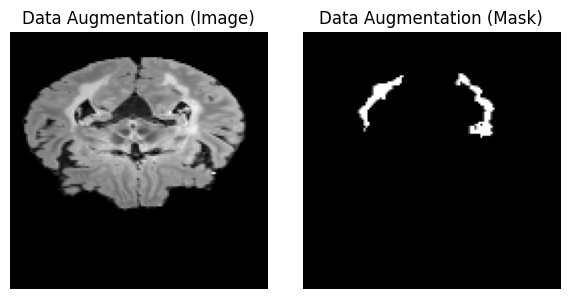

In [ ]:
# show example data augmentation
images, masks = next(iter(trainLoader))
images = images[0].numpy()
masks = masks[0].numpy()

fig_rows = 1
fig_cols = 2

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[6, 3])

axs.flat[0].set_title('Data Augmentation (Image)')
axs.flat[0].imshow(images[0,:,:], cmap='gray')
axs.flat[0].axis('off')
axs.flat[1].set_title('Data Augmentation (Mask)')
axs.flat[1].imshow(masks, cmap='gray')
axs.flat[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Build Model, optimizer, scheduler, specify Loss Func, etc.
model = Unet2D().to(DEVICE)
lossFunc = SoftDice()
optimizer = Adam(model.parameters(), lr=LR)

# schedule to decrease the initial LR to 0.1LR in the number of epochs
scheduler = lr_scheduler.LinearLR(optimizer, 1.0, 0.1, n_ep)

# for storing training history
H = {"train_loss": [], "val_loss": [], "val_dice": []}

In [ ]:
# Double check U-Net Model (show summary)
summary = summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             576
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]          73,728
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,456
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
# Training and Validation
# loop over epochs
bestDice = 0.0
for e in tqdm(range(n_ep)):
    # train
    model.train()
    # initialize metrics
    trainLoss = 0.0
    valLoss = 0.0
    valDice = 0.0
    train_ct = 0.0
    val_ct = 0.0
    # loop through training set in batches
    for idx, data in enumerate(trainLoader):
        x = data[0].to(DEVICE)
        y = data[1].unsqueeze(1).to(DEVICE)

        y_hat = model(x)
        
        loss = lossFunc(y, y_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
        trainLoss += loss
        train_ct += 1.0

    with torch.no_grad():
        # validate
        model.eval()
        # loop through validation set in batches
        for data in valLoader:
            x = data[0].to(DEVICE)
            y = data[1].unsqueeze(1).to(DEVICE)

            y_hat = model(x)

            loss = lossFunc(y, y_hat)

            valLoss += loss
            val_ct += 1.0

    # compute average metrics over datasets
    avgTrainLoss = trainLoss/train_ct
    avgValLoss = valLoss/val_ct
    avgValDice = 1-avgValLoss
    
    if bestDice < avgValDice:
        bestDice = avgValDice
        torch.save(model, 'Models/Unet_2D')        

    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_dice"].append(avgValDice.cpu().detach().numpy())

    # print metrics
    print("")
    print("Train loss: {:.4f}, Validation loss: {:.4f}, Valdiation DICE Curve: {:.4f}".format(avgTrainLoss, avgValLoss, avgValDice))

  1%|          | 1/100 [00:07<12:25,  7.53s/it]


Train loss: 0.9107, Validation loss: 0.7840, Valdiation DICE Curve: 0.2160


  2%|▏         | 2/100 [00:13<10:29,  6.42s/it]


Train loss: 0.8594, Validation loss: 0.7940, Valdiation DICE Curve: 0.2060


  3%|▎         | 3/100 [00:18<09:48,  6.07s/it]


Train loss: 0.8786, Validation loss: 0.9979, Valdiation DICE Curve: 0.0021


  4%|▍         | 4/100 [00:24<09:31,  5.95s/it]


Train loss: 0.8723, Validation loss: 0.7686, Valdiation DICE Curve: 0.2314


  5%|▌         | 5/100 [00:30<09:14,  5.84s/it]


Train loss: 0.8471, Validation loss: 0.8322, Valdiation DICE Curve: 0.1678


  6%|▌         | 6/100 [00:36<09:06,  5.81s/it]


Train loss: 0.7950, Validation loss: 0.7324, Valdiation DICE Curve: 0.2676


  7%|▋         | 7/100 [00:41<08:55,  5.76s/it]


Train loss: 0.7612, Validation loss: 0.7527, Valdiation DICE Curve: 0.2473


  8%|▊         | 8/100 [00:47<08:49,  5.76s/it]


Train loss: 0.7162, Validation loss: 0.6742, Valdiation DICE Curve: 0.3258


  9%|▉         | 9/100 [00:53<08:40,  5.72s/it]


Train loss: 0.6195, Validation loss: 0.8576, Valdiation DICE Curve: 0.1424


 10%|█         | 10/100 [00:58<08:35,  5.73s/it]


Train loss: 0.5795, Validation loss: 0.4559, Valdiation DICE Curve: 0.5441


 11%|█         | 11/100 [01:04<08:27,  5.70s/it]


Train loss: 0.5098, Validation loss: 0.6258, Valdiation DICE Curve: 0.3742


 12%|█▏        | 12/100 [01:10<08:20,  5.69s/it]


Train loss: 0.4706, Validation loss: 0.6757, Valdiation DICE Curve: 0.3243


 13%|█▎        | 13/100 [01:15<08:16,  5.71s/it]


Train loss: 0.4409, Validation loss: 0.3980, Valdiation DICE Curve: 0.6020


 14%|█▍        | 14/100 [01:21<08:12,  5.72s/it]


Train loss: 0.4068, Validation loss: 0.3552, Valdiation DICE Curve: 0.6448


 15%|█▌        | 15/100 [01:27<08:04,  5.70s/it]


Train loss: 0.3940, Validation loss: 0.3818, Valdiation DICE Curve: 0.6182


 16%|█▌        | 16/100 [01:32<07:57,  5.68s/it]


Train loss: 0.3783, Validation loss: 0.4275, Valdiation DICE Curve: 0.5725


 17%|█▋        | 17/100 [01:38<07:53,  5.70s/it]


Train loss: 0.3628, Validation loss: 0.3436, Valdiation DICE Curve: 0.6564


 18%|█▊        | 18/100 [01:44<07:48,  5.71s/it]


Train loss: 0.3547, Validation loss: 0.3434, Valdiation DICE Curve: 0.6566


 19%|█▉        | 19/100 [01:50<07:43,  5.72s/it]


Train loss: 0.3436, Validation loss: 0.2977, Valdiation DICE Curve: 0.7023


 20%|██        | 20/100 [01:55<07:35,  5.70s/it]


Train loss: 0.3695, Validation loss: 0.3109, Valdiation DICE Curve: 0.6891


 21%|██        | 21/100 [02:01<07:28,  5.68s/it]


Train loss: 0.3495, Validation loss: 0.3398, Valdiation DICE Curve: 0.6602


 22%|██▏       | 22/100 [02:07<07:25,  5.72s/it]


Train loss: 0.3141, Validation loss: 0.2886, Valdiation DICE Curve: 0.7114


 23%|██▎       | 23/100 [02:12<07:18,  5.69s/it]


Train loss: 0.3284, Validation loss: 0.3049, Valdiation DICE Curve: 0.6951


 24%|██▍       | 24/100 [02:18<07:11,  5.68s/it]


Train loss: 0.3227, Validation loss: 0.3832, Valdiation DICE Curve: 0.6168


 25%|██▌       | 25/100 [02:24<07:05,  5.67s/it]


Train loss: 0.3242, Validation loss: 0.3453, Valdiation DICE Curve: 0.6547


 26%|██▌       | 26/100 [02:29<06:58,  5.66s/it]


Train loss: 0.3294, Validation loss: 0.3925, Valdiation DICE Curve: 0.6075


 27%|██▋       | 27/100 [02:35<06:54,  5.68s/it]


Train loss: 0.3078, Validation loss: 0.2656, Valdiation DICE Curve: 0.7344


 28%|██▊       | 28/100 [02:41<06:50,  5.70s/it]


Train loss: 0.2941, Validation loss: 0.2468, Valdiation DICE Curve: 0.7532


 29%|██▉       | 29/100 [02:46<06:43,  5.68s/it]


Train loss: 0.2983, Validation loss: 0.2852, Valdiation DICE Curve: 0.7148


 30%|███       | 30/100 [02:52<06:39,  5.71s/it]


Train loss: 0.3081, Validation loss: 0.2339, Valdiation DICE Curve: 0.7661


 31%|███       | 31/100 [02:58<06:32,  5.69s/it]


Train loss: 0.2884, Validation loss: 0.2853, Valdiation DICE Curve: 0.7147


 32%|███▏      | 32/100 [03:04<06:28,  5.71s/it]


Train loss: 0.2951, Validation loss: 0.2326, Valdiation DICE Curve: 0.7674


 33%|███▎      | 33/100 [03:09<06:21,  5.69s/it]


Train loss: 0.2899, Validation loss: 0.4000, Valdiation DICE Curve: 0.6000


 34%|███▍      | 34/100 [03:15<06:14,  5.67s/it]


Train loss: 0.3061, Validation loss: 0.2673, Valdiation DICE Curve: 0.7327


 35%|███▌      | 35/100 [03:20<06:08,  5.67s/it]


Train loss: 0.2747, Validation loss: 0.2669, Valdiation DICE Curve: 0.7331


 36%|███▌      | 36/100 [03:26<06:05,  5.72s/it]


Train loss: 0.2801, Validation loss: 0.2181, Valdiation DICE Curve: 0.7819


 37%|███▋      | 37/100 [03:32<05:58,  5.69s/it]


Train loss: 0.2747, Validation loss: 0.2557, Valdiation DICE Curve: 0.7443


 38%|███▊      | 38/100 [03:38<05:52,  5.68s/it]


Train loss: 0.2736, Validation loss: 0.2744, Valdiation DICE Curve: 0.7256


 39%|███▉      | 39/100 [03:43<05:46,  5.68s/it]


Train loss: 0.2711, Validation loss: 0.2736, Valdiation DICE Curve: 0.7264


 40%|████      | 40/100 [03:49<05:40,  5.67s/it]


Train loss: 0.2811, Validation loss: 0.2572, Valdiation DICE Curve: 0.7428


 41%|████      | 41/100 [03:55<05:34,  5.66s/it]


Train loss: 0.2627, Validation loss: 0.2191, Valdiation DICE Curve: 0.7809


 42%|████▏     | 42/100 [04:00<05:28,  5.66s/it]


Train loss: 0.2729, Validation loss: 0.2596, Valdiation DICE Curve: 0.7404


 43%|████▎     | 43/100 [04:06<05:22,  5.65s/it]


Train loss: 0.2807, Validation loss: 0.2509, Valdiation DICE Curve: 0.7491


 44%|████▍     | 44/100 [04:12<05:16,  5.65s/it]


Train loss: 0.2948, Validation loss: 0.2344, Valdiation DICE Curve: 0.7656


 45%|████▌     | 45/100 [04:17<05:10,  5.65s/it]


Train loss: 0.2652, Validation loss: 0.2220, Valdiation DICE Curve: 0.7780


 46%|████▌     | 46/100 [04:23<05:06,  5.68s/it]


Train loss: 0.2553, Validation loss: 0.2069, Valdiation DICE Curve: 0.7931


 47%|████▋     | 47/100 [04:29<05:00,  5.67s/it]


Train loss: 0.2578, Validation loss: 0.2864, Valdiation DICE Curve: 0.7136


 48%|████▊     | 48/100 [04:34<04:54,  5.66s/it]


Train loss: 0.2576, Validation loss: 0.2149, Valdiation DICE Curve: 0.7851


 49%|████▉     | 49/100 [04:40<04:48,  5.65s/it]


Train loss: 0.2469, Validation loss: 0.2183, Valdiation DICE Curve: 0.7817


 50%|█████     | 50/100 [04:45<04:42,  5.65s/it]


Train loss: 0.2404, Validation loss: 0.2108, Valdiation DICE Curve: 0.7892


 51%|█████     | 51/100 [04:51<04:36,  5.65s/it]


Train loss: 0.2460, Validation loss: 0.2185, Valdiation DICE Curve: 0.7815


 52%|█████▏    | 52/100 [04:57<04:31,  5.65s/it]


Train loss: 0.2308, Validation loss: 0.2131, Valdiation DICE Curve: 0.7869


 53%|█████▎    | 53/100 [05:03<04:26,  5.68s/it]


Train loss: 0.2420, Validation loss: 0.1961, Valdiation DICE Curve: 0.8039


 54%|█████▍    | 54/100 [05:08<04:20,  5.67s/it]


Train loss: 0.2320, Validation loss: 0.2087, Valdiation DICE Curve: 0.7913


 55%|█████▌    | 55/100 [05:14<04:16,  5.70s/it]


Train loss: 0.2291, Validation loss: 0.1890, Valdiation DICE Curve: 0.8110


 56%|█████▌    | 56/100 [05:20<04:10,  5.68s/it]


Train loss: 0.2433, Validation loss: 0.2058, Valdiation DICE Curve: 0.7942


 57%|█████▋    | 57/100 [05:25<04:03,  5.67s/it]


Train loss: 0.2475, Validation loss: 0.2063, Valdiation DICE Curve: 0.7937


 58%|█████▊    | 58/100 [05:31<03:57,  5.66s/it]


Train loss: 0.2535, Validation loss: 0.2328, Valdiation DICE Curve: 0.7672


 59%|█████▉    | 59/100 [05:37<03:51,  5.66s/it]


Train loss: 0.2324, Validation loss: 0.1927, Valdiation DICE Curve: 0.8073


 60%|██████    | 60/100 [05:42<03:46,  5.65s/it]


Train loss: 0.2369, Validation loss: 0.2075, Valdiation DICE Curve: 0.7925


 61%|██████    | 61/100 [05:48<03:40,  5.65s/it]


Train loss: 0.2302, Validation loss: 0.2156, Valdiation DICE Curve: 0.7844


 62%|██████▏   | 62/100 [05:53<03:34,  5.65s/it]


Train loss: 0.2227, Validation loss: 0.1948, Valdiation DICE Curve: 0.8052


 63%|██████▎   | 63/100 [05:59<03:30,  5.70s/it]


Train loss: 0.2370, Validation loss: 0.1815, Valdiation DICE Curve: 0.8185


 64%|██████▍   | 64/100 [06:05<03:24,  5.68s/it]


Train loss: 0.2275, Validation loss: 0.1847, Valdiation DICE Curve: 0.8153


 65%|██████▌   | 65/100 [06:11<03:18,  5.67s/it]


Train loss: 0.2232, Validation loss: 0.1990, Valdiation DICE Curve: 0.8010


 66%|██████▌   | 66/100 [06:16<03:12,  5.66s/it]


Train loss: 0.2301, Validation loss: 0.1827, Valdiation DICE Curve: 0.8173


 67%|██████▋   | 67/100 [06:22<03:06,  5.66s/it]


Train loss: 0.2125, Validation loss: 0.1861, Valdiation DICE Curve: 0.8139


 68%|██████▊   | 68/100 [06:27<03:00,  5.66s/it]


Train loss: 0.2183, Validation loss: 0.1874, Valdiation DICE Curve: 0.8126


 69%|██████▉   | 69/100 [06:33<02:55,  5.65s/it]


Train loss: 0.2257, Validation loss: 0.2056, Valdiation DICE Curve: 0.7944


 70%|███████   | 70/100 [06:39<02:49,  5.65s/it]


Train loss: 0.2373, Validation loss: 0.2162, Valdiation DICE Curve: 0.7838


 71%|███████   | 71/100 [06:45<02:44,  5.68s/it]


Train loss: 0.2119, Validation loss: 0.1812, Valdiation DICE Curve: 0.8188


 72%|███████▏  | 72/100 [06:50<02:38,  5.67s/it]


Train loss: 0.2165, Validation loss: 0.2333, Valdiation DICE Curve: 0.7667


 73%|███████▎  | 73/100 [06:56<02:32,  5.66s/it]


Train loss: 0.2125, Validation loss: 0.1921, Valdiation DICE Curve: 0.8079


 74%|███████▍  | 74/100 [07:01<02:27,  5.66s/it]


Train loss: 0.2125, Validation loss: 0.1885, Valdiation DICE Curve: 0.8115


 75%|███████▌  | 75/100 [07:07<02:21,  5.65s/it]


Train loss: 0.2188, Validation loss: 0.1959, Valdiation DICE Curve: 0.8041


 76%|███████▌  | 76/100 [07:13<02:15,  5.65s/it]


Train loss: 0.2194, Validation loss: 0.1824, Valdiation DICE Curve: 0.8176


 77%|███████▋  | 77/100 [07:19<02:10,  5.69s/it]


Train loss: 0.2248, Validation loss: 0.1802, Valdiation DICE Curve: 0.8198


 78%|███████▊  | 78/100 [07:24<02:04,  5.68s/it]


Train loss: 0.2122, Validation loss: 0.1845, Valdiation DICE Curve: 0.8155


 79%|███████▉  | 79/100 [07:30<02:00,  5.71s/it]


Train loss: 0.2052, Validation loss: 0.1758, Valdiation DICE Curve: 0.8242


 80%|████████  | 80/100 [07:36<01:53,  5.69s/it]


Train loss: 0.2051, Validation loss: 0.1774, Valdiation DICE Curve: 0.8226


 81%|████████  | 81/100 [07:41<01:47,  5.68s/it]


Train loss: 0.2163, Validation loss: 0.1791, Valdiation DICE Curve: 0.8209


 82%|████████▏ | 82/100 [07:47<01:42,  5.67s/it]


Train loss: 0.2159, Validation loss: 0.1944, Valdiation DICE Curve: 0.8056


 83%|████████▎ | 83/100 [07:53<01:36,  5.70s/it]


Train loss: 0.2044, Validation loss: 0.1686, Valdiation DICE Curve: 0.8314


 84%|████████▍ | 84/100 [07:58<01:30,  5.68s/it]


Train loss: 0.2038, Validation loss: 0.2487, Valdiation DICE Curve: 0.7513


 85%|████████▌ | 85/100 [08:04<01:25,  5.73s/it]


Train loss: 0.2167, Validation loss: 0.1677, Valdiation DICE Curve: 0.8323


 86%|████████▌ | 86/100 [08:10<01:19,  5.70s/it]


Train loss: 0.2081, Validation loss: 0.1958, Valdiation DICE Curve: 0.8042


 87%|████████▋ | 87/100 [08:16<01:14,  5.72s/it]


Train loss: 0.1978, Validation loss: 0.1675, Valdiation DICE Curve: 0.8325


 88%|████████▊ | 88/100 [08:21<01:08,  5.70s/it]


Train loss: 0.1941, Validation loss: 0.1900, Valdiation DICE Curve: 0.8100


 89%|████████▉ | 89/100 [08:27<01:02,  5.68s/it]


Train loss: 0.1986, Validation loss: 0.1689, Valdiation DICE Curve: 0.8311


 90%|█████████ | 90/100 [08:33<00:56,  5.67s/it]


Train loss: 0.2060, Validation loss: 0.2075, Valdiation DICE Curve: 0.7925


 91%|█████████ | 91/100 [08:38<00:50,  5.66s/it]


Train loss: 0.2186, Validation loss: 0.1760, Valdiation DICE Curve: 0.8240


 92%|█████████▏| 92/100 [08:44<00:45,  5.66s/it]


Train loss: 0.1973, Validation loss: 0.1790, Valdiation DICE Curve: 0.8210


 93%|█████████▎| 93/100 [08:50<00:39,  5.68s/it]


Train loss: 0.1965, Validation loss: 0.1669, Valdiation DICE Curve: 0.8331


 94%|█████████▍| 94/100 [08:55<00:34,  5.71s/it]


Train loss: 0.2065, Validation loss: 0.1653, Valdiation DICE Curve: 0.8347


 95%|█████████▌| 95/100 [09:01<00:28,  5.69s/it]


Train loss: 0.2044, Validation loss: 0.1663, Valdiation DICE Curve: 0.8337


 96%|█████████▌| 96/100 [09:07<00:22,  5.68s/it]


Train loss: 0.2089, Validation loss: 0.1657, Valdiation DICE Curve: 0.8343


 97%|█████████▋| 97/100 [09:12<00:16,  5.67s/it]


Train loss: 0.2157, Validation loss: 0.2060, Valdiation DICE Curve: 0.7940


 98%|█████████▊| 98/100 [09:18<00:11,  5.70s/it]


Train loss: 0.1988, Validation loss: 0.1646, Valdiation DICE Curve: 0.8354


 99%|█████████▉| 99/100 [09:24<00:05,  5.68s/it]


Train loss: 0.1959, Validation loss: 0.1685, Valdiation DICE Curve: 0.8315


100%|██████████| 100/100 [09:29<00:00,  5.70s/it]


Train loss: 0.2000, Validation loss: 0.1711, Valdiation DICE Curve: 0.8289


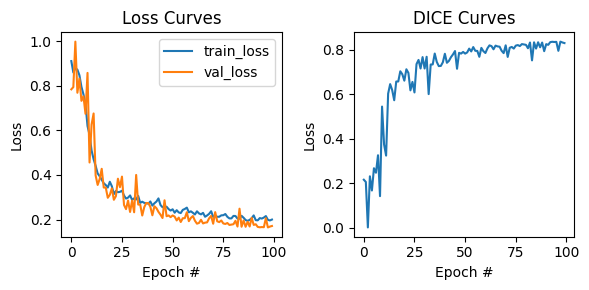

In [ ]:
# plot loss curves and DICe curves
fig_rows = 1
fig_cols = 2

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[6, 3])

axs.flat[0].set_title('Loss Curves')
axs.flat[0].plot(H["train_loss"], label="train_loss")
axs.flat[0].plot(H["val_loss"], label="val_loss")
axs.flat[0].set_xlabel("Epoch #")
axs.flat[0].set_ylabel("Loss")
axs.flat[0].legend()
axs.flat[1].set_title('DICE Curves')
axs.flat[1].plot(H["val_dice"], label="val_dice")
axs.flat[1].set_xlabel("Epoch #")
axs.flat[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

In [ ]:
# load best model
model = torch.load('Models/Unet_2D')

In [ ]:
# Testing Set
test_ct = 0.0
testDice = 0.0
with torch.no_grad():
  for data in testLoader:
    x = data[0].to(DEVICE)
    y = data[1].unsqueeze(1).to(DEVICE)

    y_hat = model(x)
    dice = 1-lossFunc(y, y_hat)
    testDice += dice
    test_ct += 1

avgDice = testDice/test_ct
print('Average DICE over Testing Set: {:.4f}'.format(avgDice.cpu().detach().numpy()))

Average DICE over Testing Set: 0.8324


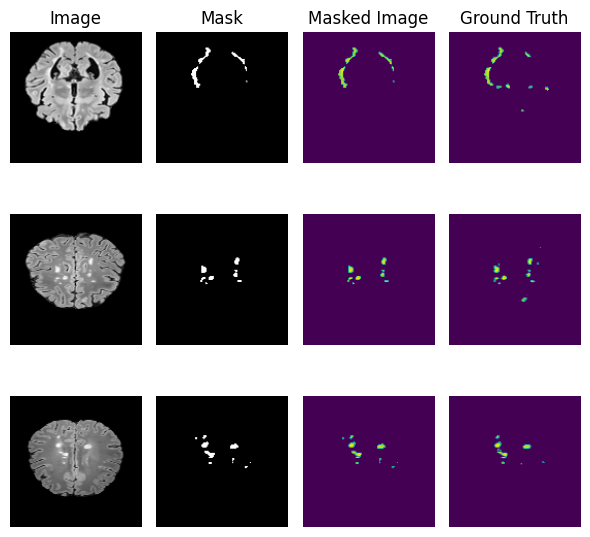

In [ ]:
# Example Segmentation from Validation Set
images, masks = next(iter(testLoader))   #training data
y_hat = model(images.to(DEVICE))
im1 = images[0].cpu().numpy().transpose((1, 2, 0))
im2 = images[3].cpu().numpy().transpose((1, 2, 0))
im3 = images[5].cpu().numpy().transpose((1, 2, 0))
mask1 = y_hat[0].detach().cpu().numpy().transpose((1, 2, 0))
mask2 = y_hat[3].detach().cpu().numpy().transpose((1, 2, 0))
mask3 = y_hat[5].detach().cpu().numpy().transpose((1, 2, 0))
im_m1 = im1*mask1
im_m2 = im2*mask2
im_m3 = im3*mask3
gt_mask1 = masks[0].detach().cpu().numpy()
gt_mask2 = masks[3].detach().cpu().numpy()
gt_mask3 = masks[5].detach().cpu().numpy()
gt_mask1 = np.expand_dims(gt_mask1, axis=2)
gt_mask2 = np.expand_dims(gt_mask2, axis=2)
gt_mask3 = np.expand_dims(gt_mask3, axis=2)
gt_m1 = im1*gt_mask1
gt_m2 = im2*gt_mask2
gt_m3 = im3*gt_mask3

fig_rows = 3
fig_cols = 4

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[6, 6])

axs.flat[0].set_title('Image')
axs.flat[0].imshow(im1, cmap='gray')
axs.flat[0].axis('off')
axs.flat[1].set_title('Mask')
axs.flat[1].imshow(mask1, cmap='gray')
axs.flat[1].axis('off')
axs.flat[2].set_title('Masked Image')
axs.flat[2].imshow(im_m1)
axs.flat[2].axis('off')
axs.flat[3].set_title('Ground Truth')
axs.flat[3].imshow(gt_m1)
axs.flat[3].axis('off')
axs.flat[4].imshow(im2, cmap='gray')
axs.flat[4].axis('off')
axs.flat[5].imshow(mask2, cmap='gray')
axs.flat[5].axis('off')
axs.flat[6].imshow(im_m2)
axs.flat[6].axis('off')
axs.flat[7].imshow(gt_m2)
axs.flat[7].axis('off')
axs.flat[8].imshow(im3, cmap='gray')
axs.flat[8].axis('off')
axs.flat[9].imshow(mask3, cmap='gray')
axs.flat[9].axis('off')
axs.flat[10].imshow(im_m3)
axs.flat[10].axis('off')
axs.flat[11].imshow(gt_m3)
axs.flat[11].axis('off')

plt.tight_layout()
plt.show()